# Data Analysis using Youtube API

In [1]:
#import libraries
from googleapiclient.discovery import build
import pandas as pd
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from dateutil.parser import parse
import YoutubeAPIFunctions
import GetAPI
#NLP
from wordcloud import WordCloud
import nltk

from nltk.corpus import stopwords

Required here to use a developer API key

In [45]:
#Keys
api_key = GetAPI.get_api_key()
api_service_name = "youtube"
api_version = "v3"

In [46]:
# Channels to analyze 
channel_ids = ['UC2dMML4l3XHrOlPYtsNL_vQ',
                #more channels here
                ]

In [47]:
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [48]:
# Get channel stats
channel_stats = YoutubeAPIFunctions.get_channel_stats(youtube, channel_ids)

In [49]:
playlist_id = "UU2dMML4l3XHrOlPYtsNL_vQ"

In [50]:
# Get video IDs
video_ids = YoutubeAPIFunctions.get_video_ids(youtube, playlist_id)

In [51]:
# Get video details
video_df = YoutubeAPIFunctions.get_video_details(youtube, video_ids)

# Data pre-processing

In [52]:
# change fields to numerical data
numeric_cols = ['viewCount', 'likeCount', 'favoriteCount' , 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [53]:
# published date
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [54]:
# convert duration into seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [55]:
# add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

# Data analysis

# Best performing videos

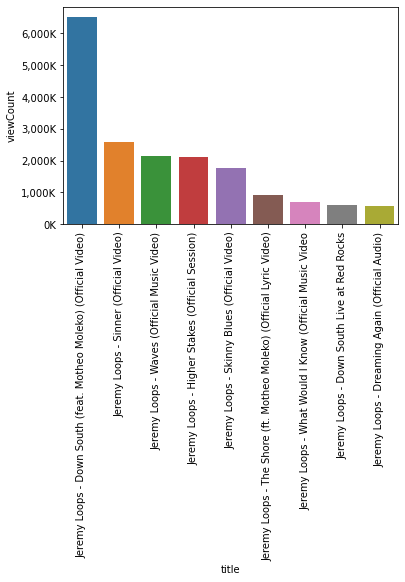

In [56]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

# Worst performing videos

C:\Users\chris\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chris\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


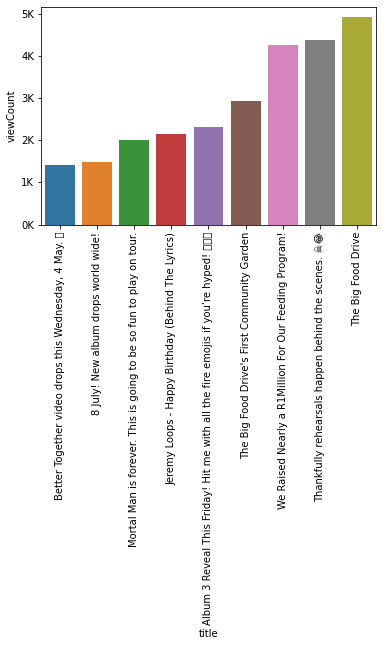

In [57]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

# View distribution per video

<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

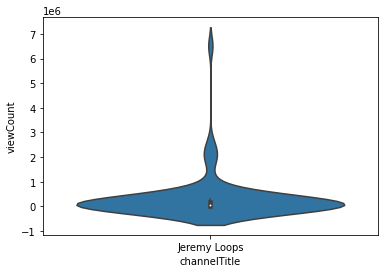

In [58]:
sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])

# Views vs. likes & comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

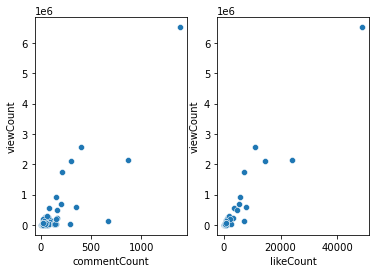

In [59]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

# Video duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

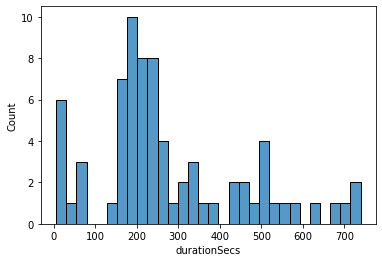

In [60]:
sns.histplot(data = video_df, x = 'durationSecs', bins = 30)

# Wordcloud for video titles

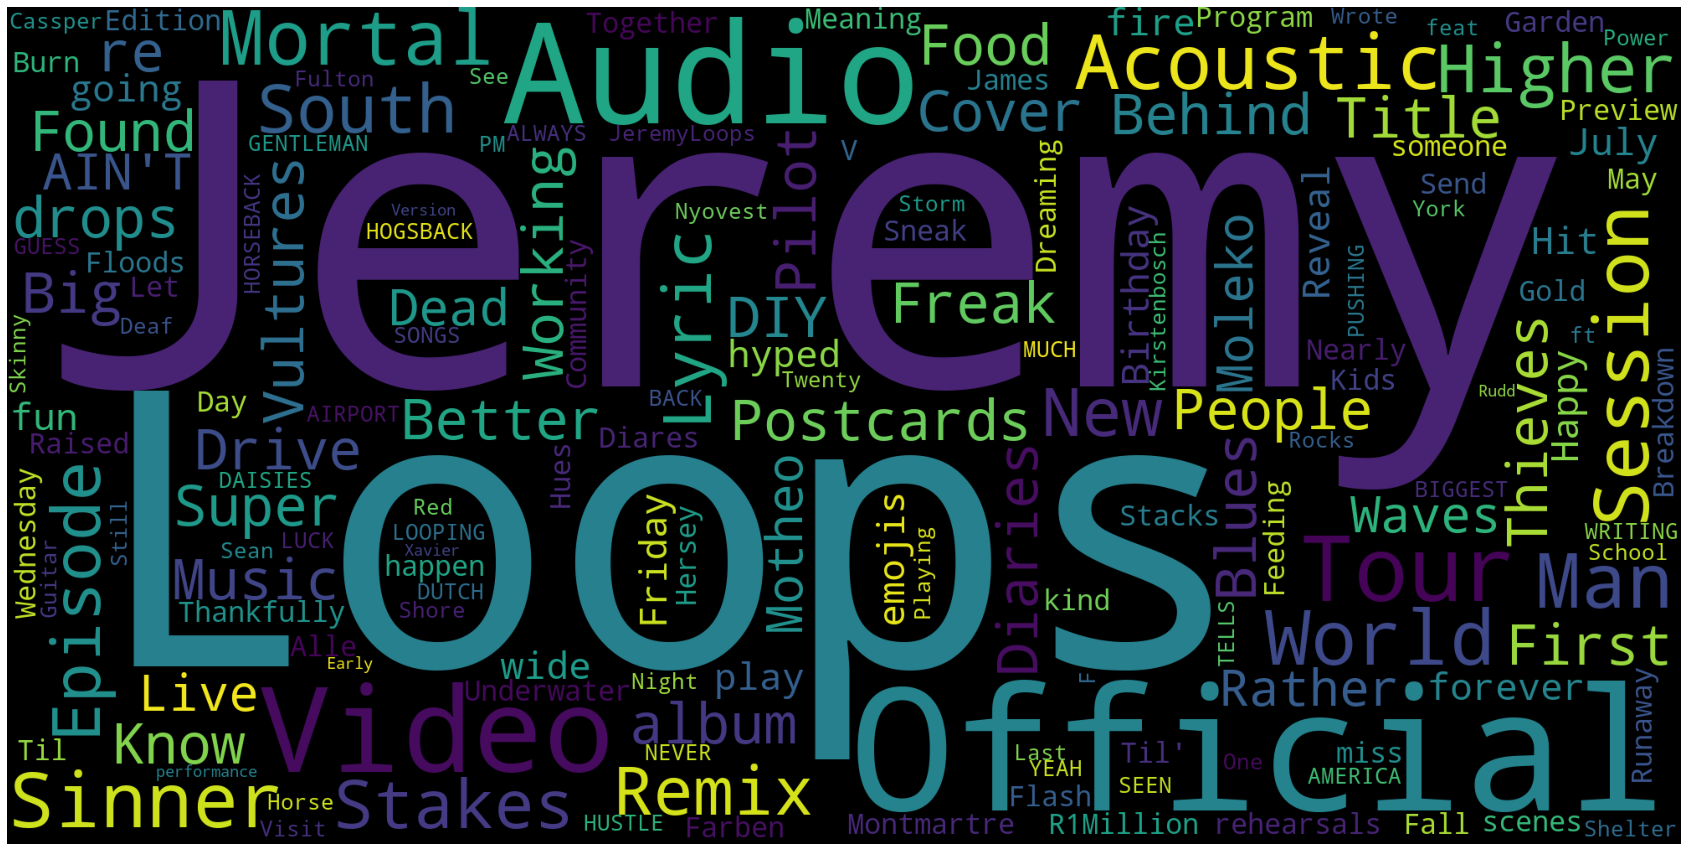

In [61]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize = (30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")
    
wordcloud = WordCloud(width = 2000, height = 1000, random_state =1, background_color = 'black',
                     colormap = 'viridis', collocations = False).generate(all_words_str)
plot_cloud(wordcloud)

# Upload schedule

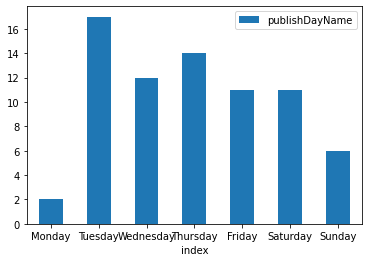

In [62]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x = 'index', y = 'publishDayName', rot = 0)